In [1]:
from sms.data.utils.pyramid_embedding_dataloader2 import PyramidEmbeddingDataloader
from sms.data.utils.dino_dataloader2 import DinoDataloader
from sms.encoders.image_encoder import BaseImageEncoderConfig
from sms.encoders.openclip_encoder import OpenCLIPNetworkConfig
from torch.utils import data
from typing import Dict, ForwardRef, Generic, List, Literal, Optional, Tuple, Type, Union, cast, get_args, get_origin
from torchvision import transforms
import matplotlib.pyplot as plt
from nerfstudio.utils.colormaps import apply_colormap
import torch

device = 'cuda:0'
"""The device to run on"""
patch_tile_size_range: Tuple[int, int] = (0.08, 0.5)
"""The range of tile sizes to sample from for patch-based training"""
patch_tile_size_res: int = 7
"""The number of tile sizes to sample from for patch-based training"""
patch_stride_scaler: float = 0.5
"""The stride scaler for patch-based training"""
network: BaseImageEncoderConfig = OpenCLIPNetworkConfig(device=device)
"""specifies the vision-language network config"""
clip_downscale_factor: int = 1
"""The downscale factor for the clip pyramid"""

dino_dataloader = DinoDataloader(
            # image_list=images,
            device=device,
            cfg={"image_shape": [480,640]},
            # cache_path=dino_cache_path,
        )
torch.cuda.empty_cache()

clip_interpolator = PyramidEmbeddingDataloader(
    device=device,
    cfg={
        "tile_size_range": list(patch_tile_size_range),
        "tile_size_res": patch_tile_size_res,
        "stride_scaler": patch_stride_scaler,
        "image_shape": [480,640],
    },
    model=network.setup()
)
image_encoder = clip_interpolator.model

transform = transforms.Compose([
    transforms.ToTensor()
])

/home/yujustin/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import torchvision
import numpy as np
from matplotlib import pyplot as plt
def tt2clipinterp(tt_frame, clip_downscale_factor=1):
    to_pil = torchvision.transforms.ToPILImage()
    image = transform(to_pil(tt_frame.permute(2, 0, 1).to(torch.uint8)))
    clip_interpolator.generate_clip_interp(image)
    H, W = image.shape[1:]
    # scale = torch.tensor(0.1).to(device)
    scaled_height = H//clip_downscale_factor
    scaled_width = W//clip_downscale_factor

    x = torch.arange(0, scaled_width*clip_downscale_factor, clip_downscale_factor).view(1, scaled_width, 1).expand(scaled_height, scaled_width, 1).to(device)
    y = torch.arange(0, scaled_height*clip_downscale_factor, clip_downscale_factor).view(scaled_height, 1, 1).expand(scaled_height, scaled_width, 1).to(device)
    image_idx_tensor = torch.zeros(scaled_height, scaled_width, 1).to(device)
    positions = torch.cat((image_idx_tensor, y, x), dim=-1).view(-1, 3).to(int)
    with torch.no_grad():
        # data["clip"], data["clip_scale"] = clip_interpolator(positions, scale)[0], clip_interpolator(positions, scale)[1]
        data = clip_interpolator(positions)[0].view(H, W, -1)
    return data

def tt2dino(tt_frame, clip_downscale_factor=1):
    im = tt_frame.permute(2, 0, 1).to(torch.float32)
    dino_dataloader.generate_dino_embed(im)
    H, W = im.shape[1:]
    # scale = torch.tensor(0.1).to(device)
    scaled_height = H//clip_downscale_factor
    scaled_width = W//clip_downscale_factor

    x = torch.arange(0, scaled_width*clip_downscale_factor, clip_downscale_factor).view(1, scaled_width, 1).expand(scaled_height, scaled_width, 1).to(device)
    y = torch.arange(0, scaled_height*clip_downscale_factor, clip_downscale_factor).view(scaled_height, 1, 1).expand(scaled_height, scaled_width, 1).to(device)
    image_idx_tensor = torch.zeros(scaled_height, scaled_width, 1).to(device)
    positions = torch.cat((image_idx_tensor, y, x), dim=-1).view(-1, 3).to(int)
    # print(positions.device)
    with torch.no_grad():
        data = dino_dataloader(positions.cpu()).view(H, W, -1)
    return data

In [3]:
from PIL import Image
im_frame1 = Image.open('test_imgs/BWWK/IMG_6409.jpeg')
im_frame1 = im_frame1.resize((640, 480))
np_frame1 = np.array(im_frame1)

In [4]:
tt_frame1 = torch.from_numpy(np_frame1).cuda()

print("Tensor Frame Datatype: ", tt_frame1.dtype)
clip_frame1 = tt2clipinterp(tt_frame1)

print(clip_frame1.shape)

Tensor Frame Datatype:  torch.uint8


Scales: 100%|██████████| 7/7 [00:00<00:00, 8552.32it/s]


here 38 32 19
here 72 36 36
here 105 52 52
here 139 69 69
here 172 86 86
here 206 103 103
here 240 120 120


Scales:   0%|          | 0/7 [00:00<?, ?it/s]/home/yujustin/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Scales: 100%|██████████| 7/7 [00:00<00:00, 13.50it/s]

PyramidEmbeddingProcess took 0.5194334983825684 seconds
torch.Size([480, 640, 512])


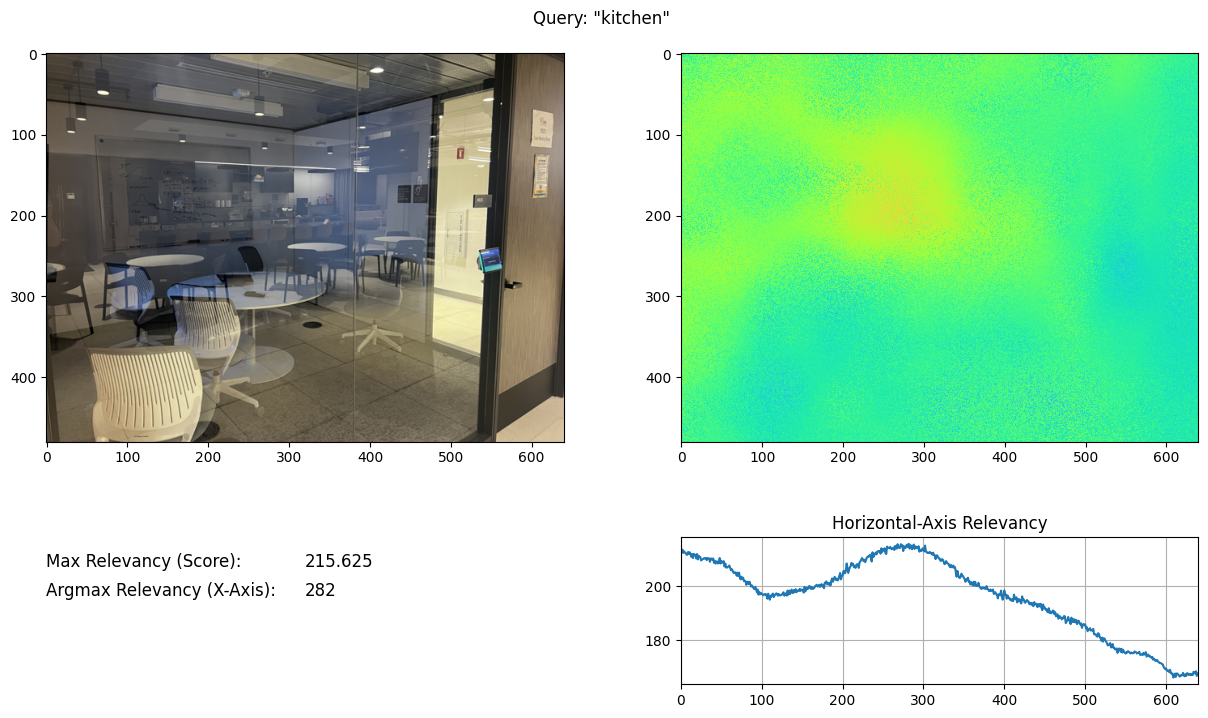

In [16]:
positive = ['kitchen']
H = clip_frame1.shape[0]
W = clip_frame1.shape[1]
image_encoder.set_positives(positive)
probs1 = image_encoder.get_relevancy(clip_frame1.view(-1, image_encoder.embedding_dim), 0)
h_axis_clip_signal = torch.sum(probs1.reshape([H,W,2]), dim=0)
color = apply_colormap(probs1[..., 0:1])
color = color.reshape([H,W,3])
# print(probs1)
# Show image and heatmap side by side
fig, ax = plt.subplots(2, 2, height_ratios=[3, 1])
plt.tight_layout()
ax[0][0].imshow(np_frame1)
fig.set_figheight(7.5)
fig.set_figwidth(13)
ax[0][1].imshow(color.cpu().numpy())
ax[1][0].axis('off')
ax[1][0].text(0, 0.8, 'Max Relevancy (Score): ', fontsize = 12)
ax[1][0].text(0.5, 0.8, str(h_axis_clip_signal[:, 0].max().item()), fontsize = 12)
ax[1][0].text(0, 0.6, "Argmax Relevancy (X-Axis): ", fontsize = 12)
ax[1][0].text(0.5, 0.6, str(h_axis_clip_signal[:, 0].argmax().item()), fontsize = 12)

ax[1][1].plot(h_axis_clip_signal[:,0].cpu().numpy())
ax[1][1].set_xlim([0, W])
# ax[1][1].set_ylim(ymin=0)
ax[1][1].grid()
ax[1][1].set_title("Horizontal-Axis Relevancy")

fig.suptitle("Query: \"" + positive[0] + "\"")
plt.savefig(f"test_clip_interp_{positive}.png")

In [6]:
im_frame2 = Image.open('test_imgs/BWWK/IMG_6416.jpeg')
im_frame2 = im_frame2.resize((640, 480))
np_frame2 = np.array(im_frame2)
tt_frame2 = torch.from_numpy(np_frame2).cuda()
clip_frame2 = tt2clipinterp(tt_frame2)

Scales: 100%|██████████| 7/7 [00:00<00:00, 9902.24it/s]


here 38 32 19
here 72 36 36
here 105 52 52
here 139 69 69
here 172 86 86
here 206 103 103
here 240 120 120


Scales:  14%|█▍        | 1/7 [00:00<00:00,  6.01it/s]

Scales: 100%|██████████| 7/7 [00:00<00:00, 15.46it/s]

PyramidEmbeddingProcess took 0.45355772972106934 seconds


In [17]:
positive = ['kitchen']
H = clip_frame2.shape[0]
W = clip_frame2.shape[1]
image_encoder.set_positives(positive)
probs2 = image_encoder.get_relevancy(clip_frame2.view(-1, image_encoder.embedding_dim), 0)
h_axis_clip_signal = torch.sum(probs2.reshape([H,W,2]), dim=0)
color = apply_colormap(probs2[..., 0:1])
color = color.reshape([H,W,3])
# Show image and heatmap side by side

fig, ax = plt.subplots(2, 2, height_ratios=[3, 1])
plt.tight_layout()
ax[0][0].imshow(np_frame2)
fig.set_figheight(7.5)
fig.set_figwidth(13)
ax[0][1].imshow(color.cpu().numpy())
ax[1][0].axis('off')
ax[1][0].text(0, 0.8, 'Max Relevancy (Score): ', fontsize = 12)
ax[1][0].text(0.5, 0.8, str(h_axis_clip_signal[:, 0].max().item()), fontsize = 12)
ax[1][0].text(0, 0.6, "Argmax Relevancy (X-Axis): ", fontsize = 12)
ax[1][0].text(0.5, 0.6, str(h_axis_clip_signal[:, 0].argmax().item()), fontsize = 12)
ax[1][1].plot(h_axis_clip_signal[:,0].cpu().numpy())
ax[1][1].set_xlim([0, W])
# ax[1][1].set_ylim(ymin=0)
ax[1][1].grid()
ax[1][1].set_title("Horizontal-Axis Relevancy")

fig.suptitle("Query: \"" + positive[0] + "\"")
plt.savefig(f"test_clip_interp_{positive}.png")

SyntaxError: invalid syntax (1794946817.py, line 21)